## Import packages

In [39]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    average_precision_score, confusion_matrix, log_loss, cohen_kappa_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV

## Load data, making sure to drop the serial number column, which is not useful for classification

In [40]:
train_df = pd.read_csv('datasets/train.csv', index_col=0)
test_df = pd.read_csv('datasets/test.csv', index_col=0)

## Clean data

In [41]:
train_df.head()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2,EVENT
0,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,0
1,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,0
2,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,0
3,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,0
4,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,0


### Columns that have only one unique value aren't useful to classification, and should be dropped

In [42]:
train_df['Tp'].unique()

array([6.5       , 6.6       , 6.7       , ..., 9.00663063, 8.41352575,
       8.22963054], shape=(31635,))

In [43]:
test_df.head()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2,EVENT
0,10.1,0.17,8.41,762.0,190.0,0.022,0.106,1818.0,920.0,0
1,10.1,0.18,8.41,762.0,190.0,0.022,0.106,1805.0,927.0,0
2,10.1,0.19,8.41,762.0,189.0,0.022,0.108,1787.0,927.0,0
3,10.1,0.18,8.41,762.0,190.0,0.022,0.108,1790.0,936.0,0
4,10.1,0.18,8.41,762.0,189.0,0.022,0.108,1827.0,924.0,0


In [44]:
test_df['EVENT'].unique()

array([0, 1])

## Check datatypes

In [45]:
train_df.dtypes

Tp       float64
Cl       float64
pH       float64
Redox    float64
Leit     float64
Trueb    float64
Cl_2     float64
fm       float64
Fm_2     float64
EVENT      int64
dtype: object

In [46]:
test_df.dtypes

Tp       float64
Cl       float64
pH       float64
Redox    float64
Leit     float64
Trueb    float64
Cl_2     float64
fm       float64
Fm_2     float64
EVENT      int64
dtype: object

## Format data for XGBoost

### Split test and training data into X_train, y_train, X_test, y_test

In [47]:
X_train = train_df.drop(columns=['EVENT']) # Features
y_train = train_df['EVENT'] # Labels
X_test = test_df.drop(columns=['EVENT'])
y_test = test_df['EVENT']

In [48]:
X_train.head()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2
0,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0
1,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0
2,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0
3,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0
4,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0


In [49]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: EVENT, dtype: int64

In [50]:
X_test.head()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2
0,10.1,0.17,8.41,762.0,190.0,0.022,0.106,1818.0,920.0
1,10.1,0.18,8.41,762.0,190.0,0.022,0.106,1805.0,927.0
2,10.1,0.19,8.41,762.0,189.0,0.022,0.108,1787.0,927.0
3,10.1,0.18,8.41,762.0,190.0,0.022,0.108,1790.0,936.0
4,10.1,0.18,8.41,762.0,189.0,0.022,0.108,1827.0,924.0


In [51]:
y_test.head()

0    0
1    0
2    0
3    0
4    0
Name: EVENT, dtype: int64

## Build initial model with early stopping

In [52]:
start_time = time.time()

model = xgb.XGBClassifier(objective="binary:logistic", missing=np.nan, seed=42, early_stopping_rounds=10, eval_metric='aucpr', verbosity=1)

In [53]:
model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time:.4f} seconds")

[0]	validation_0-aucpr:0.07407
[1]	validation_0-aucpr:0.07642
[2]	validation_0-aucpr:0.09512
[3]	validation_0-aucpr:0.09038
[4]	validation_0-aucpr:0.20048
[5]	validation_0-aucpr:0.22645
[6]	validation_0-aucpr:0.12716
[7]	validation_0-aucpr:0.21921
[8]	validation_0-aucpr:0.21260
[9]	validation_0-aucpr:0.18979
[10]	validation_0-aucpr:0.20664
[11]	validation_0-aucpr:0.20412
[12]	validation_0-aucpr:0.21504
[13]	validation_0-aucpr:0.21433
[14]	validation_0-aucpr:0.22630
[15]	validation_0-aucpr:0.22953
[16]	validation_0-aucpr:0.23742
[17]	validation_0-aucpr:0.24217
[18]	validation_0-aucpr:0.24636
[19]	validation_0-aucpr:0.26029
[20]	validation_0-aucpr:0.24466
[21]	validation_0-aucpr:0.25721
[22]	validation_0-aucpr:0.25414
[23]	validation_0-aucpr:0.26390
[24]	validation_0-aucpr:0.26742
[25]	validation_0-aucpr:0.26995
[26]	validation_0-aucpr:0.27085
[27]	validation_0-aucpr:0.26311
[28]	validation_0-aucpr:0.27310
[29]	validation_0-aucpr:0.27127
[30]	validation_0-aucpr:0.27279
[31]	validation_0-

## Get predictions from model

In [54]:
y_pred = model.predict(X_test)

## Plot confusion matrix

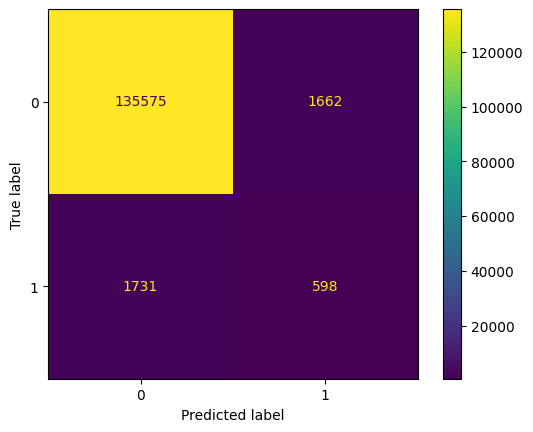

In [55]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Get other metrics

In [56]:
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for positive class only

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba))
print("PR-AUC (Average Precision): ", average_precision_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0,1]))
print("Log Loss: ", log_loss(y_test, y_pred_proba))
print("Cohen's Kappa: ", cohen_kappa_score(y_test, y_pred))

Accuracy:  0.9756889213705344
Precision:  0.2646017699115044
Recall:  0.2567625590382138
F1 Score:  0.26062322946175637
ROC-AUC:  0.7114238144964975
PR-AUC (Average Precision):  0.2756817015227641
Confusion Matrix:
 [[135575   1662]
 [  1731    598]]
Log Loss:  0.10097984959400425
Cohen's Kappa:  0.24826735044932613


## Optimize hyperparameters using GridSearchCV and cross validation

### Round 1:

In [57]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

In [58]:
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        seed=42,
        subsample=0.9,
        colsample_bytree=0.5,
        early_stopping_rounds=10, 
        eval_metric='auc',
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3,
)

In [59]:
optimal_params.fit(
    X_train, y_train, eval_set=[(X_test, y_test)], verbose=False
)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 1.0, 10.0],
                         'scale_pos_weight': [1, 3, 5]},
             scoring='roc_auc')

In [60]:
print(optimal_params.best_params_)

{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 3}


### Round 2

In [61]:
param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [1.0, 1.5, 2.0],
    'reg_lambda': [0],
    'scale_pos_weight': [3]
}

In [62]:
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        seed=42,
        subsample=0.9,
        colsample_bytree=0.5,
        early_stopping_rounds=10, 
        eval_metric='auc',
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3,
)

In [63]:
optimal_params.fit(
    X_train, y_train, eval_set=[(X_test, y_test)], verbose=False
)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'gamma': [1.0, 1.5, 2.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 6, 7], 'reg_lambda': [0],
                         'scale_pos_weight': [3]},
             scoring='roc_auc')

In [64]:
print(optimal_params.best_params_)

{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0, 'scale_pos_weight': 3}


### Training again with these hyper params

In [65]:
start_time = time.time()
optimized_model = xgb.XGBClassifier(
    seed=42,
    objective='binary:logistic',
    gamma=1.0,
    learning_rate=0.1,
    max_depth=7,
    reg_lambda=0,
    scale_pos_weight=3,
    subsample=0.9,
    colsample_bytree=0.5,
    early_stopping_rounds=10,
    eval_metric='aucpr',
)

In [66]:
optimized_model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time:.4f} seconds")

[0]	validation_0-aucpr:0.22388
[1]	validation_0-aucpr:0.22462
[2]	validation_0-aucpr:0.17343
[3]	validation_0-aucpr:0.20286
[4]	validation_0-aucpr:0.18908
[5]	validation_0-aucpr:0.19606
[6]	validation_0-aucpr:0.26021
[7]	validation_0-aucpr:0.31291
[8]	validation_0-aucpr:0.30781
[9]	validation_0-aucpr:0.30346
[10]	validation_0-aucpr:0.29707
[11]	validation_0-aucpr:0.30316
[12]	validation_0-aucpr:0.28740
[13]	validation_0-aucpr:0.29091
[14]	validation_0-aucpr:0.28317
[15]	validation_0-aucpr:0.27393
[16]	validation_0-aucpr:0.26943
[17]	validation_0-aucpr:0.29578
Training time: 1.5279 seconds


In [70]:
y_pred = optimized_model.predict(X_test)

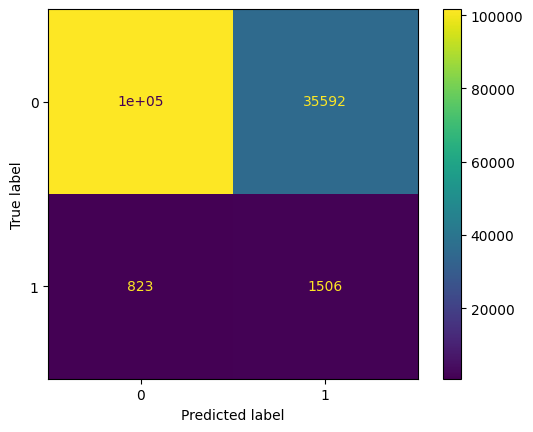

In [71]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [72]:
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for positive class only

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba))
print("PR-AUC (Average Precision): ", average_precision_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0,1]))
print("Log Loss: ", log_loss(y_test, y_pred_proba))
print("Cohen's Kappa: ", cohen_kappa_score(y_test, y_pred))

Accuracy:  0.7390840175974092
Precision:  0.0405951803331716
Recall:  0.6466294547015886
F1 Score:  0.0763943490501433
ROC-AUC:  0.7114238144964975
PR-AUC (Average Precision):  0.2756817015227641
Confusion Matrix:
 [[101645  35592]
 [   823   1506]]
Log Loss:  0.10097984959400425
Cohen's Kappa:  0.046449629090670186
